In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model_path = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import csv
with open('/content/drive/MyDrive/Colab Notebooks/LLM ROBERTA/train_essays.csv', mode ='r')as file:
  csvtrain = pd.read_csv(file)

with open('/content/drive/MyDrive/Colab Notebooks/LLM ROBERTA/test_essays.csv', mode ='r')as file:
  csvtest = pd.read_csv(file)

Mounted at /content/drive


In [ ]:
csvtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         159 non-null    object
 1   prompt_id  159 non-null    int64 
 2   text       159 non-null    object
 3   generated  159 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.1+ KB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
csvtrain.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


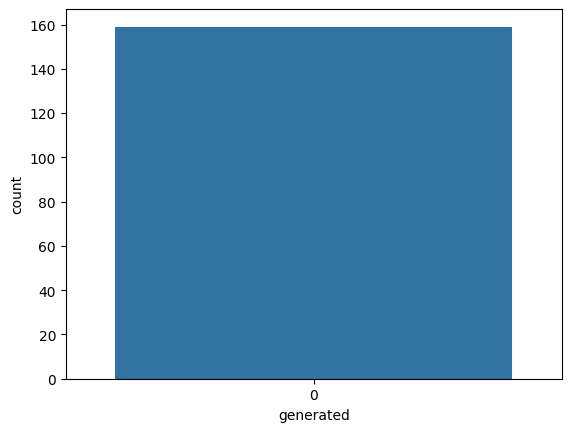

In [ ]:
sns.countplot(data=csvtrain, x='generated')
plt.show()

In [ ]:
!python -m nltk.downloader stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

csvtrain['clean_text'] = csvtrain['text'].apply(clean_text)

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(csvtrain['clean_text'], csvtrain['generated'], test_size=0.2, random_state=42)

In [ ]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [ ]:
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained("roberta-base")


num_classes = 2


model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)


print(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from transformers import AdamW, get_scheduler


optimizer = AdamW(model.parameters(), lr=3e-5)


num_epochs = 1


num_training_steps = num_epochs * len(train_loader)


lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


print(lr_scheduler)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

gradient_accumulation_steps = 1
total_steps = len(train_loader) // gradient_accumulation_steps

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss /= gradient_accumulation_steps
        total_loss += loss.item()

        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.2f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Average Training Loss: 0.63


In [ ]:

model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:

val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 1.00


In [22]:


test_inputs = tokenizer(csvtest['text'].tolist(), padding=True, truncation=True, return_tensors='pt')


test_inputs = {key: value.to(device) for key, value in test_inputs.items()}


with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits


predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()


submission = pd.DataFrame({
    'id': csvtest['id'],
    'generated': predictions
})


submission.to_csv('/content/drive/MyDrive/Colab Notebooks/LLM ROBERTA/submission.csv', index=False)

submission.head(2)

,id,generated
0,0000aaaa,0.480818
1,1111bbbb,0.483354
